# Modeling OPEC Sentiment vs PP Prices
Predict next-month PP_EU using GPT comparison scores, hybrid index, FinBERT sentiment, and keyword densities.

In [1]:

from pathlib import Path
BASE_DIR = Path.cwd()
if BASE_DIR.name == 'notebooks':
    BASE_DIR = BASE_DIR.parent

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

sns.set_style('whitegrid')

data_path = BASE_DIR / 'data' / 'processed' / 'master_opec_price_model_dataset.csv'
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.head()

PLOTS = BASE_DIR / 'plots'
PLOTS.mkdir(parents=True, exist_ok=True)

## Dataset overview
Columns include raw GPT comparison scores, cumulative hybrid index, FinBERT sentiment, keyword densities, and market prices aligned to month-end.

In [2]:
df.describe(include='all').T


,count,mean,min,25%,50%,75%,max,std
date,80,2022-05-26 19:12:00,2019-01-31 00:00:00,2020-09-22 12:00:00,2022-05-15 12:00:00,2024-02-07 06:00:00,2025-09-30 00:00:00,NaN
comparison_score,80.0,0.11625,-0.9,-0.45,0.35,0.6,0.8,0.563094
hybrid_index,80.0,-0.59625,-10.8,-5.525,-0.75,5.05,9.3,5.840007
finbert_sentiment,80.0,-0.046661,-0.245568,-0.119719,-0.057719,0.027162,0.300448,0.114086
supply_up,80.0,0.00598,0.000517,0.003641,0.006189,0.008089,0.012422,0.002935
supply_down,80.0,0.002217,0.0002,0.001404,0.001944,0.002726,0.008483,0.001372
demand_up,80.0,0.002424,0.00005,0.001324,0.002092,0.003445,0.00717,0.001556
demand_down,80.0,0.002306,0.000265,0.001469,0.001999,0.002699,0.007567,0.00139
price_up,80.0,0.000221,0.0,0.000025,0.000046,0.000456,0.000958,0.000294
price_down,80.0,0.000401,0.0,0.000048,0.000112,0.00064,0.001873,0.000494


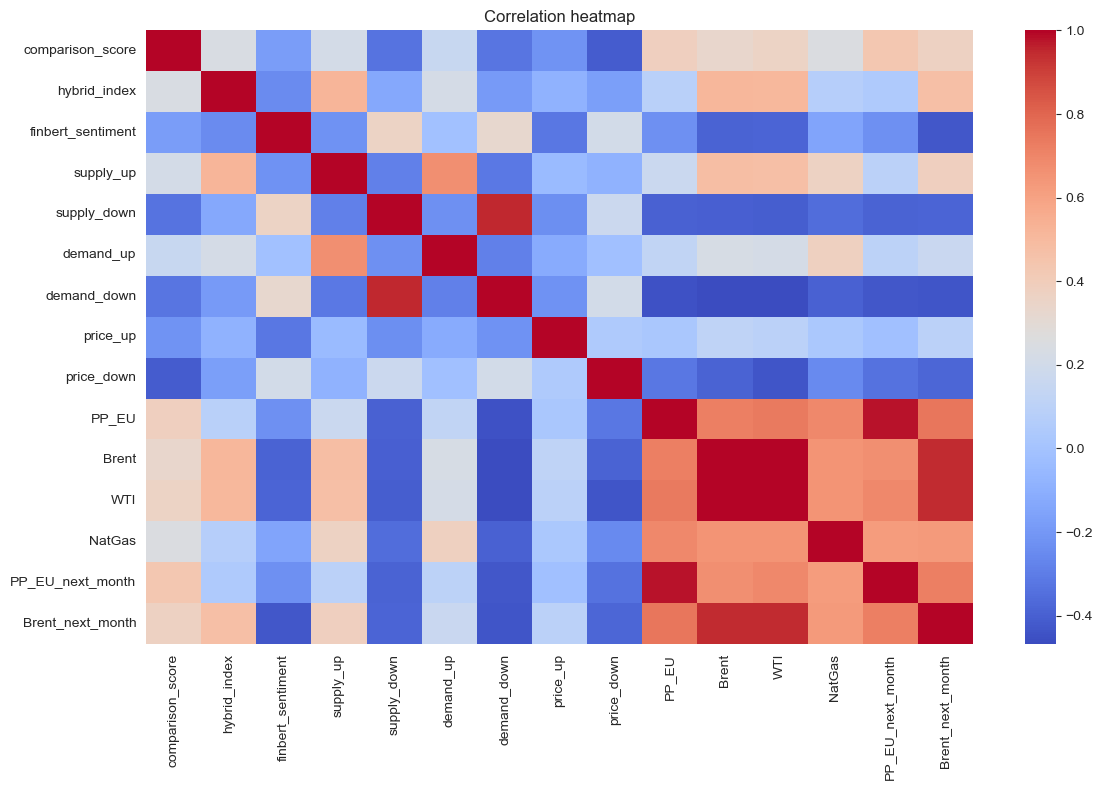

In [3]:
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation heatmap')
plt.tight_layout()
plt.savefig(PLOTS / 'modeling04_corr_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


## Train/validation split
Use the earliest 80% of months for training and the latest 20% for validation to respect time order.

In [4]:
feature_cols = [
    'comparison_score', 'hybrid_index', 'finbert_sentiment',
    'supply_up', 'supply_down', 'demand_up', 'demand_down',
    'price_up', 'price_down', 'Brent', 'WTI', 'NatGas', 'PP_EU',
]

target = 'PP_EU_next_month'
split_idx = int(len(df) * 0.8)
X_train, X_val = df.loc[:split_idx - 1, feature_cols], df.loc[split_idx:, feature_cols]
y_train, y_val = df.loc[:split_idx - 1, target], df.loc[split_idx:, target]
dates_val = df.loc[y_val.index, 'date']

naive_pred = df.loc[y_val.index, 'PP_EU']
naive_mae = mean_absolute_error(y_val, naive_pred)
print('Naive MAE (predict current PP as next month):', round(naive_mae, 2))


Naive MAE (predict current PP as next month): 11.25


In [5]:
rf = RandomForestRegressor(n_estimators=300, random_state=42, min_samples_leaf=2)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_mae = mean_absolute_error(y_val, rf_pred)

xgb = XGBRegressor(
    random_state=42, n_estimators=400, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)
xgb_mae = mean_absolute_error(y_val, xgb_pred)

results = pd.DataFrame(
    [
        ['Naive (current PP)', naive_mae],
        ['RandomForest', rf_mae],
        ['XGBoost', xgb_mae],
    ],
    columns=['model', 'mae']
)
results


,model,mae
0,Naive (current PP),11.250000
1,RandomForest,23.632629
2,XGBoost,37.491753


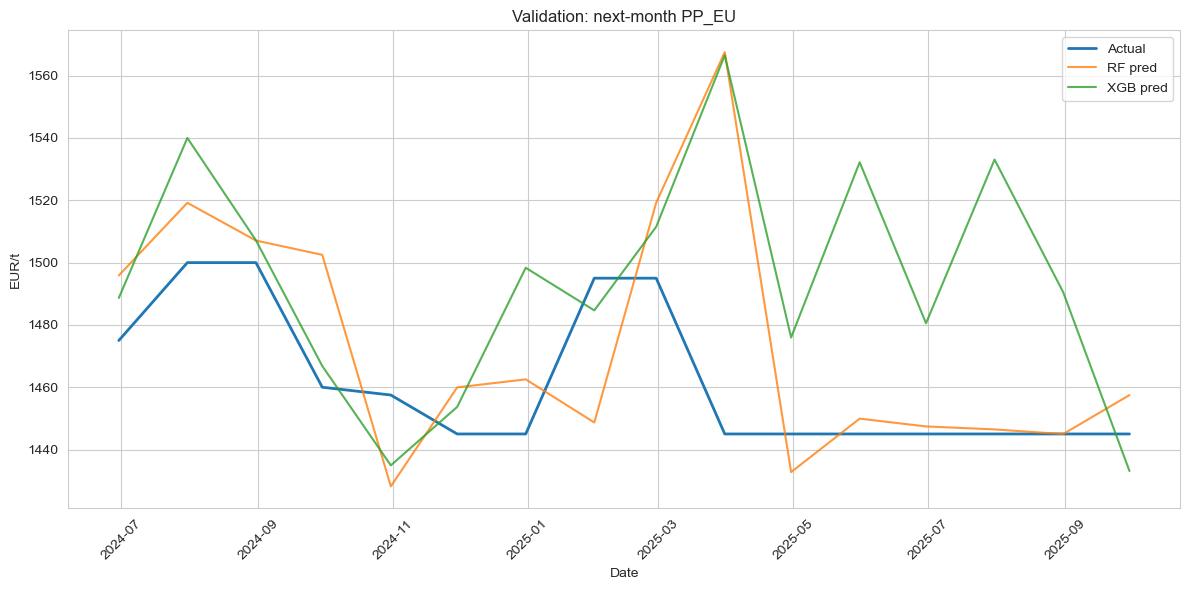

In [6]:
val_df = pd.DataFrame({
    'date': dates_val,
    'actual': y_val.values,
    'rf_pred': rf_pred,
    'xgb_pred': xgb_pred,
})

plt.figure(figsize=(12, 6))
plt.plot(val_df['date'], val_df['actual'], label='Actual', linewidth=2)
plt.plot(val_df['date'], val_df['rf_pred'], label='RF pred', alpha=0.8)
plt.plot(val_df['date'], val_df['xgb_pred'], label='XGB pred', alpha=0.8)
plt.legend()
plt.title('Validation: next-month PP_EU')
plt.xlabel('Date')
plt.ylabel('EUR/t')
plt.xticks(rotation=45)
plt.tight_layout()
plt.tight_layout()
plt.savefig(PLOTS / 'modeling04_validation_preds.png', dpi=150, bbox_inches='tight')
plt.show()
